In [1]:
AVAILABLE_GPU = 3 # Available GPU with 0% usage
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = f"{AVAILABLE_GPU}"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
tf_device=f'/gpu:{AVAILABLE_GPU}'

In [2]:
import sys
sys.path.append('../Utils')

In [3]:
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer


from DataManagement import preparar_datos
from Constants import SEED
from DataManagement import createDataloaders
from Utils import get_loss_opt
from Utils import train
from Utils import evalua
from Utils import count_parameters
from Models import SentimentAnalysisPretrainedBert
from Utils import verify_model
from Constants import TRAINING_DATA

/home/historynlp/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. UNCASED

## 1.1 Definicion de constantes

In [4]:
#Modelo bert a usar
BERT_MODEL = '../../output/albert/old-spanish-albert-base-uncased.pt'

#Dispositivo sobre el que se corre el modelo de ML
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizer_uncased = AutoTokenizer.from_pretrained("dccuchile/albert-base-spanish")
torch.cuda.empty_cache()
DEVICE

device(type='cuda')

## 1.2 Creacion de los dataloaders

In [5]:
datos = preparar_datos(TRAINING_DATA)
train_df, test_df = train_test_split(datos, test_size=0.2, random_state = SEED, shuffle=True)
val_df, test_df = train_test_split(test_df, test_size=0.5, random_state = SEED, shuffle=True)

train_loader_uncased, val_loader_uncased, test_loader_uncased = createDataloaders(train_df, val_df, test_df, tokenizer_uncased)

## 1.3 Creación y evaluación del modelo con el bert entrenado

### 1.3.1 Entrenamiento

In [7]:
torch.manual_seed(SEED)
classificator_uncased = SentimentAnalysisPretrainedBert(BERT_MODEL, 0.4, 4, 256, 128, True).to(DEVICE)
count_parameters(classificator_uncased)

11580956

In [7]:
criterio, optimizer = get_loss_opt(classificator_uncased)
train(classificator_uncased, '../StoredModels/Mejores_guardados_albert_uncased.pt', train_loader_uncased, val_loader_uncased, optimizer, criterio)

 33%|██████████████▎                            | 20/60 [12:18<24:25, 36.64s/it]


Epoch: 20 | Training acc: 0.5478750640040962 | Training loss: 0.12649735013338706 | Val acc: 0.5163934426229508 | Val loss: 0.1265086490111273
------------------------------------------------------------------------------------------------------------------------------------------------------


 67%|████████████████████████████▋              | 40/60 [24:29<12:11, 36.55s/it]


Epoch: 40 | Training acc: 0.6646185355862775 | Training loss: 0.11088816054771938 | Val acc: 0.5942622950819673 | Val loss: 0.11707085517586255
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|███████████████████████████████████████████| 60/60 [36:41<00:00, 36.68s/it]


Epoch: 60 | Training acc: 0.6692268305171531 | Training loss: 0.10949640217891914 | Val acc: 0.6024590163934426 | Val loss: 0.11553970663273921
------------------------------------------------------------------------------------------------------------------------------------------------------


(inf, 0.6794674859190988)

### 1.3.2 Validación

In [8]:
# Cargar un modelo que ya había sido Finetuneado
checkpoint_classifier = torch.load(
    "../StoredModels/Mejores_guardados_albert_uncased.pt",
    map_location=torch.device(DEVICE)
)

classificator_uncased.load_state_dict(checkpoint_classifier['model_state_dict'])

<All keys matched successfully>

100%|███████████████████████████████████████████| 31/31 [00:02<00:00, 11.81it/s]


Statistics: 
              precision    recall  f1-score   support

    NEGATIVO       0.77      0.54      0.64        79
      NEUTRO       0.51      0.69      0.58        61
    POSITIVO       0.66      0.67      0.66       105

    accuracy                           0.63       245
   macro avg       0.64      0.63      0.63       245
weighted avg       0.66      0.63      0.64       245



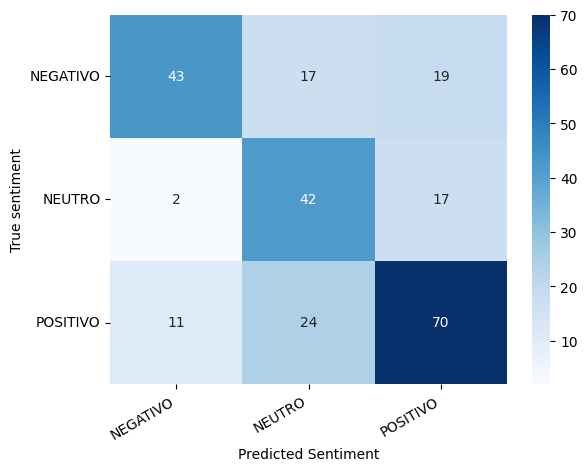

({'NEGATIVO': 0.20862529, 'NEUTRO': 0.59387666, 'POSTIVO': 0.16966917, 'IRONIA': 0.027828839}, 'NEUTRO')


In [9]:
# Obtener las predicciones
results = verify_model(classificator_uncased, test_loader_uncased, tokenizer_uncased)

In [10]:
del classificator_uncased
torch.cuda.empty_cache()

## 1.4 Creación y evaluación del modelo sin el Bert Entrenado

### 1.4.1 Entrenamiento

In [11]:
torch.manual_seed(SEED)
classificator_uncased_no_bert = SentimentAnalysisPretrainedBert(BERT_MODEL, 0.4, 4, 256, 128, False).to(DEVICE)
count_parameters(classificator_uncased_no_bert)

230276

In [12]:
criterio, optimizer = get_loss_opt(classificator_uncased_no_bert)
train(classificator_uncased_no_bert, '../StoredModels/Mejores_guardados_albert_uncased_no_bert.pt', train_loader_uncased, val_loader_uncased, optimizer, criterio)

 33%|██████████████▎                            | 20/60 [05:12<10:28, 15.72s/it]


Epoch: 20 | Training acc: 0.41781874039938555 | Training loss: 0.13687598564901904 | Val acc: 0.42213114754098363 | Val loss: 0.13872911231439622
------------------------------------------------------------------------------------------------------------------------------------------------------


 67%|████████████████████████████▋              | 40/60 [10:24<05:10, 15.50s/it]


Epoch: 40 | Training acc: 0.42498719918074757 | Training loss: 0.13518341885916832 | Val acc: 0.4180327868852459 | Val loss: 0.1370363770449748
------------------------------------------------------------------------------------------------------------------------------------------------------


100%|███████████████████████████████████████████| 60/60 [15:38<00:00, 15.63s/it]


Epoch: 60 | Training acc: 0.4572452636968766 | Training loss: 0.1335381279221206 | Val acc: 0.39344262295081966 | Val loss: 0.13601771021475556
------------------------------------------------------------------------------------------------------------------------------------------------------


(inf, 0.4572452636968766)

### 1.4.2 Validación

In [13]:
# Cargar un modelo que ya había sido Finetuneado
checkpoint_classifier = torch.load(
    "../StoredModels/Mejores_guardados_albert_uncased_no_bert.pt",
    map_location=torch.device(DEVICE)
)

classificator_uncased_no_bert.load_state_dict(checkpoint_classifier['model_state_dict'])

<All keys matched successfully>

100%|███████████████████████████████████████████| 31/31 [00:01<00:00, 18.12it/s]
/home/historynlp/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/historynlp/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/historynlp/venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_

Statistics: 
              precision    recall  f1-score   support

    NEGATIVO       0.00      0.00      0.00        79
      NEUTRO       0.31      0.36      0.33        61
    POSITIVO       0.47      0.77      0.58       105

    accuracy                           0.42       245
   macro avg       0.26      0.38      0.30       245
weighted avg       0.28      0.42      0.33       245



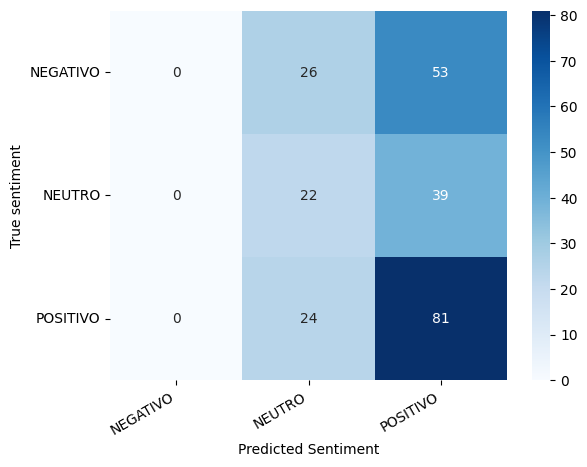

({'NEGATIVO': 0.2691701, 'NEUTRO': 0.36013827, 'POSTIVO': 0.36696443, 'IRONIA': 0.0037272014}, 'POSITIVO')


In [14]:
# Obtener las predicciones
verify_model(classificator_uncased_no_bert, test_loader_uncased, tokenizer_uncased)

In [15]:
del classificator_uncased_no_bert
torch.cuda.empty_cache()

In [16]:
print(f"Memoria total reservada en CUDA: {torch.cuda.memory_reserved(0)} bytes")
print(f"Memoria actualmente asignada en CUDA: {torch.cuda.memory_allocated(0)} bytes")

Memoria total reservada en CUDA: 167772160 bytes
Memoria actualmente asignada en CUDA: 95422464 bytes


In [11]:
results.head()

,Review Text,Prediction,Probability Negative,Probability Neutral,Probability Positive,Real Value
0,"catedral, dando instrucciones verbales a los o...",2,0.155432,0.167240,0.653529,2
1,"en mi calidad de simple cortesano del genio, d...",2,0.127134,0.179424,0.676381,0
2,pared un parapeto por falta de una bicoca en q...,1,0.128391,0.669301,0.177409,2
3,"la casa cural, regalada por una senora conde e...",1,0.121451,0.665356,0.186842,2
4,escena 5. a criado. aqui teneis los tizones !...,1,0.151997,0.520192,0.313164,1


In [12]:
results.to_csv('../Validation/Albert.csv')

In [18]:
len(datos)

2442

In [20]:
len(train_df)

1953

In [21]:
len(test_df)

245

In [22]:
len(val_df)

244

In [ ]:
datos

,text,TAG_num
0,caro al pudor y grato a la inocencia. que llo...,1
1,i aun para que los sacaran tres horas antes de...,0
3,"aparato enganoso de la ficcion, esta la leccio...",2
5,"las tradiciones medrosas, refieren extranisima...",2
6,por retardarla provocase ni admitiese necesar...,0
...,...,...
2729,"venga una paz estable y duradera, y el suelo q...",2
2730,cada dia nuevas flores en el camino que transi...,2
2731,de la respuesta dada por el senor docter velez...,0
2732,"paris, diciembre 11 . el examen de pretara e...",0


In [12]:
def calculate(datos):
    irony = len(datos[datos['TAG_num']==3])
    neutro = len(datos[datos['TAG_num']==1])
    positive = len(datos[datos['TAG_num']==2])
    negative = len(datos[datos['TAG_num']==0])
    total = len(datos)

    print(f' irony: {irony} \n positive: {positive} \n neutro: {neutro} \n negative {negative} \n total: {len(datos)}')
    print(f' irony: {irony/total} \n positive: {positive/total} \n neutro: {neutro/total} \n negative {negative/total}')

In [13]:
calculate(datos)

 irony: 0 
 positive: 951 
 neutro: 790 
 negative 701 
 total: 2442
 irony: 0.0 
 positive: 0.3894348894348894 
 neutro: 0.3235053235053235 
 negative 0.2870597870597871


In [14]:
calculate(train_df)

 irony: 0 
 positive: 753 
 neutro: 656 
 negative 544 
 total: 1953
 irony: 0.0 
 positive: 0.38556067588325654 
 neutro: 0.3358934971838198 
 negative 0.27854582693292373


In [15]:
calculate(test_df)

 irony: 0 
 positive: 105 
 neutro: 61 
 negative 79 
 total: 245
 irony: 0.0 
 positive: 0.42857142857142855 
 neutro: 0.24897959183673468 
 negative 0.3224489795918367


In [16]:
calculate(val_df)

 irony: 0 
 positive: 93 
 neutro: 73 
 negative 78 
 total: 244
 irony: 0.0 
 positive: 0.38114754098360654 
 neutro: 0.29918032786885246 
 negative 0.319672131147541


In [21]:
292/2734

0.10680321872713973